# Import Statements

In [157]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint 

# Load and Prepare Data

### Format of the data

1. last column of the data must contain the label and if must also be called "label"
2. there shoud be no missing values in the data frame

In [158]:
df=pd.read_csv('Iris.csv')
df=df.drop("Id",axis=1)
df=df.rename(columns={"Species": "label","PetalWidthCm": "petal_Width","PetalLengthCm": "petal_length",
                      "SepalWidthCm":"sepal_width","SepalLengthCm":"sepal_length"})

# Train-Test_Split

In [159]:
def train_test_split(df,test_size):
    if isinstance(test_size,float):
        test_size=round(test_size*len(df))

    indices=df.index.tolist()
    test_indices=random.sample(population=indices,k=test_size)

    test_df=df.loc[test_indices]
    train_df=df.drop(test_indices)
    return train_df, test_df
random.seed(0)
train_df,test_df=train_test_split(df,test_size=10)
test_df.head()

,sepal_length,sepal_width,petal_length,petal_Width,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


# Data Pure

In [160]:
data=train_df.values
#converting data to numpy (faster than pandas)
def check_purity(data):
    label_column=data[:,-1]
    unique_classes=np.unique(label_column)
    if len(unique_classes)==1:
        return True
    else:
        return False

# Classify

In [161]:
def classify_data(data):
    label_column=data[:,-1]
    unique_classes,counts_unique_classes=np.unique(label_column,return_counts=True)
    index=counts_unique_classes.argmax()
    classificaion=unique_classes[index]
    return classificaion
classify_data(train_df[train_df.petal_Width>0.8].values)

'Iris-versicolor'

# Potential splits

In [163]:
train_df.head()

,sepal_length,sepal_width,petal_length,petal_Width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [171]:

def get_potential_splits(data):
    potential_splits={}
    _,n_columns=data.shape
    for column_index in range(n_columns-1):
        potential_splits[column_index]=[]
        values=data[:,column_index]
        unique_values=np.unique(values)

        for index in range(len(unique_values)):
            if index!=0:
                current_value=unique_values[index]
                previous_value=unique_values[index-1]
                potential_split=(current_value+previous_value)/2
                potential_splits[column_index].append(potential_split)

    return potential_splits

potential_splits=get_potential_splits(train_df.values)
    

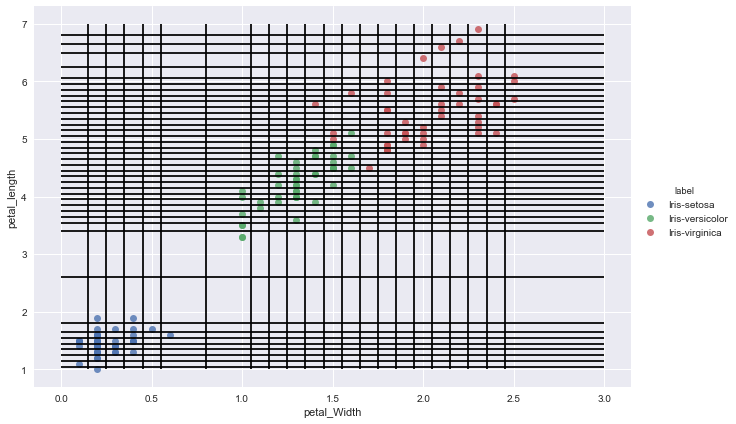

In [179]:
sns.lmplot(data=train_df,x='petal_Width',y='petal_length',hue='label',fit_reg=False,size=6,aspect=1.5)

plt.pyplot.vlines(x=potential_splits[3],ymin=1,ymax=7)
plt.pyplot.hlines(y=potential_splits[2],xmin=0,xmax=3)

# Split data

In [220]:
split_column=3
split_value=0.8

def split_data(data,split_column,split_value):
    split_column_values=data[:,split_column]
    
    data_below=data[split_column_values<=split_value]
    data_above=data[split_column_values>split_value]
    
    return data_below,data_above


In [222]:
data_below,data_above=split_data(data,split_column,split_value)

(0, 2.6)

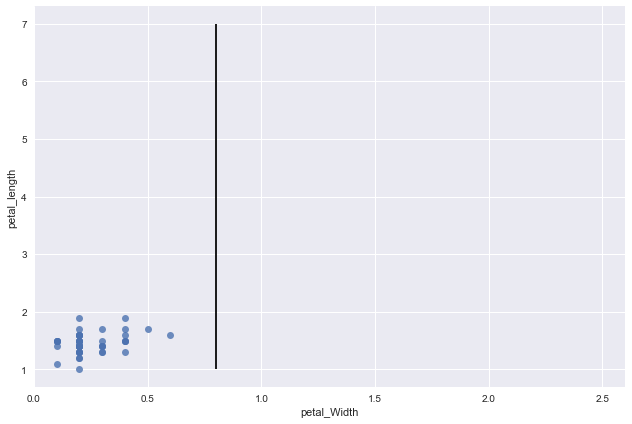

In [236]:
plotting_df=pd.DataFrame(data_below,columns=df.columns)
sns.lmplot(data=plotting_df,x="petal_Width",y="petal_length",fit_reg=False,size=6,aspect=1.5)
plt.pyplot.vlines(split_value,ymin=1,ymax=7)
plt.pyplot.xlim(0,2.6)